# Early Patient Readmission

Garrett Lappe

garrett.l.lappe@gmail.com

# Part One - EDA

In [1]:
import pandas as pd
import numpy as np
import gc

In [2]:
data_dir = 'data\\'

na_values = ['?','null','unknown', 'Unknown/Invalid', 'NULL', '']

data = pd.read_csv(data_dir + 'diabetes_data.csv', dtype=object, na_values=na_values)
data.drop_duplicates(inplace=True)

In [6]:
data.head()

,encounter_id,patient_nbr,race,gender,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admit_date,birth_date
0,2278392,8222157,Caucasian,Female,NaN,6,25,1,1,NaN,...,No,No,No,No,No,No,No,NO,2002-10-22 06:30:00,1996-07-29 14:28:00
1,149190,55629189,Caucasian,Female,NaN,1,1,7,3,NaN,...,No,No,No,No,No,Ch,Yes,>30,2004-07-24 08:35:00,1985-09-19 11:19:00
2,64410,86047875,AfricanAmerican,Female,NaN,1,1,7,2,NaN,...,No,No,No,No,No,No,Yes,NO,2005-11-30 06:35:00,1983-07-14 07:22:00
3,500364,82442376,Caucasian,Male,NaN,1,1,7,2,NaN,...,No,No,No,No,No,Ch,Yes,NO,2003-05-26 00:32:00,1968-04-05 23:51:00
4,16680,42519267,Caucasian,Male,NaN,1,1,7,1,NaN,...,No,No,No,No,No,Ch,Yes,NO,2004-04-25 04:04:00,1957-11-18 20:30:00


In [174]:
data.dtypes

encounter_id                        object
patient_nbr                         object
race                                object
gender                              object
weight                              object
time_in_hospital                    object
payer_code                          object
medical_specialty                   object
num_lab_procedures                  object
num_procedures                      object
num_medications                     object
number_outpatient                   object
number_emergency                    object
diag_1                              object
diag_2                              object
diag_3                              object
number_diagnoses                    object
max_glu_serum                       object
A1Cresult                           object
metformin                           object
repaglinide                         object
nateglinide                         object
chlorpropamide                      object
glimepiride

In [10]:
data['readmitted'].value_counts() / len(data)

NO     0.539119
>30    0.349282
<30    0.111599
Name: readmitted, dtype: float64

#### Before going further, I will replace the category IDs with their corresponding descriptions to make analysis easier.

Replacing these IDs with np.nan will make it easier to mark these records as null/NA for data cleaning and feature engineering.

In [11]:
# will treat 6 as missing
# '6':'NULL'
admission_types = {
    '1':'Emergency',
    '2':'Urgent',
    '3':'Elective',
    '4':'Newborn',
    '5':'Not Available',
    '6':np.nan,
    '7':'Trauma Center',
    '8':'Not Mapped'}

# will treat 17, 21 as missing
# '17':'NULL'
# '21':'Unknown/Invalid'
admission_sources = {
    '1':'Physician Referral',
    '2':'Clinic Referral',
    '3':'HMO Referral',
    '4':'Transfer from a hospital',
    '5':'Transfer from a Skilled Nursing Facility (SNF)',
    '6':'Transfer from another health care facility',
    '7':'Emergency Room',
    '8':'Court/Law Enforcement',
    '9':'Not Available',
    '10':'Transfer from critial access hospital',
    '11':'Normal Delivery',
    '12':'Premature Delivery',
    '13':'Sick Baby',
    '14':'Extramural Birth',
    '15':'Not Available',
    '17': np.nan,
    '18':'Transfer From Another Home Health Agency',
    '19':'Readmission to Same Home Health Agency',
    '20':'Not Mapped',
    '21': np.nan,
    '22':'Transfer from hospital inpt/same fac reslt in a sep claim',
    '23':'Born inside this hospital',
    '24':'Born outside this hospital',
    '25':'Transfer from Ambulatory Surgery Center',
    '26':'Transfer from Hospice'}


# will treat 18, 26 as missing
# '18':'NULL'
# '26':'Unknown/Invalid'
discharge_dispositions = {
    '1':'Discharged to home',
    '2':'Discharged/transferred to another short term hospital',
    '3':'Discharged/transferred to SNF',
    '4':'Discharged/transferred to ICF',
    '5':'Discharged/transferred to another type of inpatient care institution',
    '6':'Discharged/transferred to home with home health service',
    '7':'Left AMA',
    '8':'Discharged/transferred to home under care of Home IV provider',
    '9':'Admitted as an inpatient to this hospital',
    '10':'Neonate discharged to another hospital for neonatal aftercare',
    '11':'Expired',
    '12':'Still patient or expected to return for outpatient services',
    '13':'Hospice / home',
    '14':'Hospice / medical facility',
    '15':'Discharged/transferred within this institution to Medicare approved swing bed',
    '16':'Discharged/transferred/referred another institution for outpatient services',
    '17':'Discharged/transferred/referred to this institution for outpatient services',
    '18': np.nan,
    '19':'Expired at home. Medicaid only, hospice.',
    '20':'Expired in a medical facility. Medicaid only, hospice.',
    '21':'Expired, place unknown. Medicaid only, hospice.',
    '22':'Discharged/transferred to another rehab fac including rehab units of a hospital .',
    '23':'Discharged/transferred to a long term care hospital.',
    '24':'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.',
    '25':'Not Mapped',
    '26': np.nan,
    '30':'Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere',
    '27':'Discharged/transferred to a federal health care facility.',
    '28':'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital',
    '29':'Discharged/transferred to a Critical Access Hospital (CAH).'}


# add new columns for descriptions
data['admission_type'] = data['admission_type_id'].apply(lambda x: admission_types[x] if x in admission_types else np.nan)
data['admission_source'] = data['admission_source_id'].apply(lambda x: admission_sources[x] if x in admission_sources else np.nan)
data['discharge_disposition'] = data['discharge_disposition_id'].apply(lambda x: discharge_dispositions[x] if x in discharge_dispositions else np.nan)

# drop old ID columns
data.drop(columns=['admission_type_id', 
                   'admission_source_id', 
                   'discharge_disposition_id'], axis=1, inplace=True)

In [12]:
data.columns.values

array(['encounter_id', 'patient_nbr', 'race', 'gender', 'weight',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'diag_1', 'diag_2',
       'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
       'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'admit_date', 'birth_date', 'admission_type', 'admission_source',
       'discharge_disposition'], dtype=object)

## Data Analysis and Exploration

### 1. How many rows and columns are in the dataset?

In [13]:
data.shape

(101766, 50)

101,766 rows, 50 columns

### 2. How many men are represented in the data versus women?

In [14]:
data['gender'].value_counts()  # entire dataset

Female    54708
Male      47055
Name: gender, dtype: int64

In [15]:
from matplotlib import pyplot as plt

<BarContainer object of 2 artists>

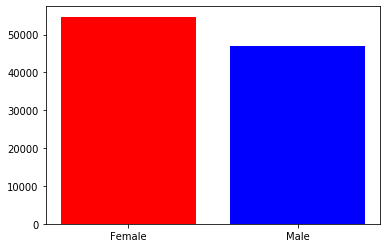

In [16]:
plt.bar(x=['Female', 'Male'], 
        height=data['gender'].value_counts(),
        color=['red', 'blue'])

Patients can appear multiple times throughout the dataset. Let's look at unique patients.

In [17]:
patient_genders = data[['patient_nbr', 'gender']].drop_duplicates()

In [18]:
len(patient_genders)

71521

In [19]:
len(data['patient_nbr'].drop_duplicates())  # interesting, there are 3 patients with multiple gender entries.

71518

In [20]:
patient_genders[patient_genders['patient_nbr'].duplicated()]

,patient_nbr,gender
29500,55500588,Male
66706,109210482,Male
76845,40867677,Female


In [21]:
# finding them
patient_genders[patient_genders['patient_nbr'].apply(lambda x: x in ['55500588', '109210482', '40867677'])] 

,patient_nbr,gender
3316,55500588,Female
29500,55500588,Male
65862,109210482,Female
66706,109210482,Male
74244,40867677,Male
76845,40867677,Female


In [22]:
# removing them from the calculation
patient_genders = patient_genders[patient_genders['patient_nbr'].apply(lambda x: x not in ['55500588', 
                                                                                           '109210482', 
                                                                                           '40867677'])]

In [23]:
patient_gender_counts = pd.DataFrame(patient_genders['gender'].value_counts()).rename(columns={'gender':'count'}).reset_index().rename(columns={'index':'gender'})

In [24]:
patient_gender_counts['proportion'] = (patient_gender_counts['count'] / len(patient_genders)).apply(lambda x: round(x,5))
patient_gender_counts

,gender,count,proportion
0,Female,38023,0.53168
1,Male,33489,0.46828


<BarContainer object of 2 artists>

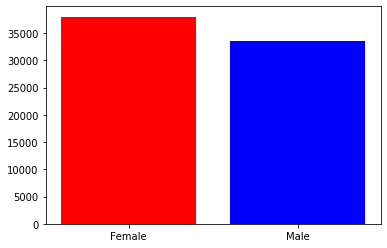

In [25]:
plt.bar(x=patient_gender_counts['gender'], 
        height=patient_gender_counts['count'], 
        color=['red', 'blue'])

Removing the 3 patient_nbrs that have both male and female gender entries, there are **38,026** unique male patients and **33,492** female patients.

**53.17%** male

**46.83%** female

### 3. Patient Democraphics - Race

In [26]:
patient_races = data[['patient_nbr', 'race']].drop_duplicates()  # same approach for race as I took with gender

In [27]:
len(patient_races)

71770

In [28]:
len(patient_races['patient_nbr'].drop_duplicates())  # again, there are several patients with multiple entries.

71518

In [29]:
patient_races[patient_races['patient_nbr'].duplicated()]

,patient_nbr,race
1157,2341521,AfricanAmerican
1918,9946782,Caucasian
2271,70269183,Caucasian
2321,7436034,Caucasian
3372,12027024,Caucasian
...,...,...
99607,38752722,Caucasian
100521,111126897,Caucasian
100904,49193784,Caucasian
101286,46488123,Caucasian


In [30]:
duplicated_race_patient_nbrs = patient_races[patient_races['patient_nbr'].duplicated()]['patient_nbr'].values

In [31]:
# removing patients listed with multiple different races from calculation
patient_races = patient_races[patient_races['patient_nbr'].apply(lambda x: x not in duplicated_race_patient_nbrs)]

In [32]:
patient_race_counts = pd.DataFrame(patient_races['race'].value_counts()).rename(columns={'race':'count'}).reset_index().rename(columns={'index':'race'})
patient_race_counts

,race,count
0,Caucasian,53428
1,AfricanAmerican,12872
2,Hispanic,1491
3,Other,1135
4,Asian,493


In [33]:
patient_race_counts['proportion'] = (patient_race_counts['count'] / len(patient_races)).apply(lambda x: round(x,5))
patient_race_counts

,race,count,proportion
0,Caucasian,53428,0.74967
1,AfricanAmerican,12872,0.18061
2,Hispanic,1491,0.02092
3,Other,1135,0.01593
4,Asian,493,0.00692


<BarContainer object of 5 artists>

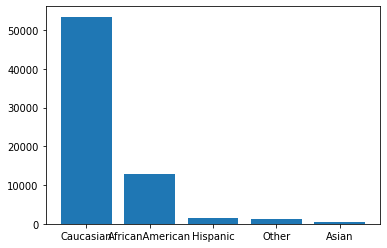

In [34]:
plt.bar(x=patient_race_counts['race'],
        height=patient_race_counts['count'])

### 4. Patient Age - Male/Female

I'll calculate the patients' *age at admission* (difference between admit_date and birth_date)

In [35]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [36]:
# casting as datetime
data['birth_date'] = pd.to_datetime(data['birth_date'])
data['admit_date'] = pd.to_datetime(data['admit_date'])

In [37]:
data['age_at_admit'] = [relativedelta(a, b).years for a, b in zip(data['admit_date'], data['birth_date'])]

In [38]:
patient_ages = data[['patient_nbr', 'age_at_admit']].drop_duplicates()

In [39]:
age_range = [i for i in range(max(patient_ages['age_at_admit'])+1)]

### 4. Patient Age - Male/Female

<BarContainer object of 108 artists>

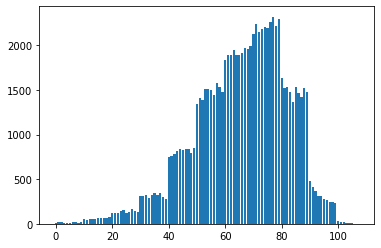

In [40]:
# histogram of patient age at admission. Interesting!
plt.bar(age_range, [patient_ages['age_at_admit'].value_counts().loc[i] for i in age_range])

If a patient appears multiple times, I will only keep only age at first admission

In [41]:
patient_ages_first = patient_ages.groupby('patient_nbr').first().reset_index()
patient_ages_first

,patient_nbr,age_at_admit
0,100000170,76
1,100001178,80
2,100002006,74
3,100002582,34
4,100002906,52
...,...,...
71513,99990405,81
71514,99994707,85
71515,99998208,61
71516,99998280,86


In [42]:
patient_ages_first = patient_ages_first.merge(patient_genders, on='patient_nbr', how='inner')
patient_ages_first

,patient_nbr,age_at_admit,gender
0,100000170,76,Female
1,100001178,80,Male
2,100002006,74,Female
3,100002582,34,Male
4,100002906,52,Male
...,...,...,...
71510,99990405,81,Female
71511,99994707,85,Female
71512,99998208,61,Female
71513,99998280,86,Female


In [43]:
import numpy as np

In [44]:
# male
avg_age_male = np.mean(patient_ages_first[patient_ages_first['gender']=='Male'].dropna()['age_at_admit'].values)
print('Male average age at first admission: {} years'.format(round(avg_age_male,2)))

# female
avg_age_female = np.mean(patient_ages_first[patient_ages_first['gender']=='Female'].dropna()['age_at_admit'].values)
print('Female average age at first admission: {} years'.format(round(avg_age_female,2)))

Male average age at first admission: 64.28 years
Female average age at first admission: 65.95 years


### 5. Missing Data -- which features have the most missing data?

In [45]:
count_nas = {}

for col in data.columns.values:
    
    num_na = sum(data[col].isna())
    proportion_na = 1.0 * num_na / len(data)
    
    count_nas[col] = {
        'count_na': num_na,
        'proportion_na': proportion_na
    }
    
    if proportion_na > 0.5:
        print('Feature {} contains {}% missing values.'.format(col, 100.0 * round(proportion_na,4)))
    elif proportion_na > 0.3:
        print('Other noteworthy missing data: Feature {} contains {}% missing values.'.format(col, 100.0 * round(proportion_na,4)))

Feature weight contains 96.86% missing values.
Other noteworthy missing data: Feature payer_code contains 39.56% missing values.
Other noteworthy missing data: Feature medical_specialty contains 49.08% missing values.


### 6. Patient readmission rate by specialty

In [46]:
specialties = data['medical_specialty'].dropna().drop_duplicates()
specialties

0        Pediatrics-Endocrinology
9                InternalMedicine
12         Family/GeneralPractice
17                     Cardiology
27                Surgery-General
                   ...           
64899                Perinatology
79594             Neurophysiology
91565    Endocrinology-Metabolism
92037                     DCPTEAM
95599                    Resident
Name: medical_specialty, Length: 72, dtype: object

In [47]:
s_df = data[data['medical_specialty'] == 'InternalMedicine']
s_df.head()

,encounter_id,patient_nbr,race,gender,weight,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,...,metformin-pioglitazone,change,diabetesMed,readmitted,admit_date,birth_date,admission_type,admission_source,discharge_disposition,age_at_admit
9,15738,63555939,Caucasian,Female,NaN,12,NaN,InternalMedicine,33,3,...,No,Ch,Yes,NO,2003-10-28 22:01:00,1913-02-15 00:25:00,Elective,Transfer from a hospital,Discharged/transferred to SNF,90
46,486156,86240259,Caucasian,Female,NaN,9,NaN,InternalMedicine,25,3,...,No,Ch,Yes,<30,2001-02-04 03:47:00,1924-07-07 06:11:00,Elective,Transfer from a hospital,Discharged/transferred to another type of inpa...,76
122,2091690,7919802,AfricanAmerican,Female,NaN,6,NaN,InternalMedicine,47,2,...,No,No,No,NO,2008-06-17 06:16:00,1959-06-22 18:12:00,NaN,Emergency Room,Not Mapped,48
125,2095932,276606,AfricanAmerican,Female,NaN,8,NaN,InternalMedicine,62,0,...,No,Ch,Yes,>30,1999-04-18 07:16:00,1968-03-06 09:33:00,NaN,Emergency Room,Not Mapped,31
132,2262036,427482,Caucasian,Female,NaN,7,NaN,InternalMedicine,72,0,...,No,Ch,Yes,>30,2000-03-03 21:44:00,1940-01-01 12:40:00,NaN,Emergency Room,Not Mapped,60


In [48]:
num_patients = len(s_df.groupby('patient_nbr').first().reset_index())
num_patients

11998

In [49]:
readmission_df = pd.DataFrame()

for s in specialties:
    s_df = data[data['medical_specialty'] == s]
    s_df_readmitted = s_df[s_df['readmitted'] == '<30']
    
    num_patients = len(s_df.groupby('patient_nbr').first().reset_index())
    num_patients_readmitted = len(s_df_readmitted.groupby('patient_nbr').first().reset_index())
    
    #print(s)
    #print('Out of {} patients, {} were readmitted within 30 days.'.format(num_patients, num_patients_readmitted))
    
    readmission_df = readmission_df.append(pd.Series([s, num_patients, num_patients_readmitted]), ignore_index=True)
    
readmission_df.columns=['medical_specialty', 'num_patients', 'num_patients_readmitted_<30_days']
readmission_df

,medical_specialty,num_patients,num_patients_readmitted_<30_days
0,Pediatrics-Endocrinology,151.0,1.0
1,InternalMedicine,11998.0,1426.0
2,Family/GeneralPractice,6053.0,756.0
3,Cardiology,4807.0,405.0
4,Surgery-General,2821.0,314.0
...,...,...,...
67,Perinatology,1.0,0.0
68,Neurophysiology,1.0,0.0
69,Endocrinology-Metabolism,7.0,1.0
70,DCPTEAM,6.0,0.0


In [50]:
readmission_df['proportion_readmitted'] = readmission_df['num_patients_readmitted_<30_days'] / readmission_df['num_patients']

readmission_df

,medical_specialty,num_patients,num_patients_readmitted_<30_days,proportion_readmitted
0,Pediatrics-Endocrinology,151.0,1.0,0.006623
1,InternalMedicine,11998.0,1426.0,0.118853
2,Family/GeneralPractice,6053.0,756.0,0.124897
3,Cardiology,4807.0,405.0,0.084252
4,Surgery-General,2821.0,314.0,0.111308
...,...,...,...,...
67,Perinatology,1.0,0.0,0.000000
68,Neurophysiology,1.0,0.0,0.000000
69,Endocrinology-Metabolism,7.0,1.0,0.142857
70,DCPTEAM,6.0,0.0,0.000000


Looking only at specialties with over 50 patients admitted, I sorted the specialties by the proportion of their patients which are readmitted within 30 days.

Unsurprisingly, the specialties with the higest rates of early patient readmission are those related to cancer, followed by a variety of specialties which often deal with high levels of physical trauma--surgery, emergency/trauma.

In [51]:
readmission_df[readmission_df['num_patients'] >= 50].sort_values(by='proportion_readmitted', ascending=False)

,medical_specialty,num_patients,num_patients_readmitted_<30_days,proportion_readmitted
55,Hematology,55.0,16.0,0.290909
17,Hematology/Oncology,150.0,33.0,0.220000
32,Oncology,266.0,50.0,0.187970
8,Nephrology,1072.0,192.0,0.179104
27,Radiology,51.0,8.0,0.156863
40,PhysicalMedicineandRehabilitation,365.0,53.0,0.145205
50,Surgery-Vascular,468.0,66.0,0.141026
11,Emergency/Trauma,5132.0,655.0,0.127631
2,Family/GeneralPractice,6053.0,756.0,0.124897
10,Psychiatry,723.0,90.0,0.124481


# Part Two - Machine Learning

### Building a predictive model to identify patients at risk of readmitting within 30 days

#### Pt 1 - Preparing data

I made these two methods to add some data on previous admissions.

1. time since last admission (if one exists)

2. number of previous admissions

In [52]:
# returns the number of days since this patien'ts previous admission as of as_of_dt
def time_since_last_admission(patient_nbr, as_of_dt, historical_df):
    
    this_patient_df = historical_df[historical_df['patient_nbr']==patient_nbr]  # make df for this patient's history
    this_patient_df = this_patient_df[this_patient_df['admit_date'] < as_of_dt]  # look only at ones prior to observed date
    
    num_prev = len(this_patient_df)
    
    if num_prev==0:
        return np.nan
    
    previous_admission = this_patient_df.tail(1)
    
    delta = relativedelta(as_of_dt, pd.to_datetime(previous_admission['admit_date'].values[0]))
    
    delta_days = delta.years*365 + delta.months*30 + delta.days  # approximation
    return delta_days


# returns the total number of previous admissions as of as_of_dt
def num_previous_admissions(patient_nbr, as_of_dt, historical_df):
    
    this_patient_df = historical_df[historical_df['patient_nbr']==patient_nbr]  # make df for this patient's history
    this_patient_df = this_patient_df[this_patient_df['admit_date'] < as_of_dt]  # look only at ones prior to observed date
    
    num_prev = len(this_patient_df)
    
    return num_prev


In [53]:
from sklearn.preprocessing import scale

In [54]:
# takes raw-ish dataframe df and returns a dataframe X for model building
def process_data(df):
    X = pd.DataFrame()
    
    X['race'] = df['race'].astype('category')
    X['gender'] = df['gender'].astype('category')
    X['time_in_hospital'] = df['time_in_hospital'].astype(int)
    X['payer_code'] = df['payer_code'].astype('category')
    X['medical_specialty'] = df['medical_specialty'].astype('category')
    X['num_lab_procedures'] = scale(df['num_lab_procedures'].values)
    X['num_procedures'] = df['num_procedures'].astype(int)
    X['num_medications'] = scale(df['num_medications'].values)
    X['number_outpatient'] = scale(df['number_outpatient'].values)
    X['number_emergency'] = scale(df['number_emergency'].values)
    X['diag_1'] = df['diag_1'].astype('category')
    X['diag_2'] = df['diag_2'].astype('category')
    X['diag_3'] = df['diag_3'].astype('category')
    
    X['number_diagnoses'] = df['number_diagnoses'].astype(int)
    X['max_glu_serum'] = df['max_glu_serum'].astype('category')
    X['A1Cresult'] = df['A1Cresult'].astype('category')
    X['metformin'] = df['metformin'].astype('category')
    X['repaglinide'] = df['repaglinide'].astype('category')
    X['nateglinide'] = df['nateglinide'].astype('category')
    X['chlorpropamide'] = df['chlorpropamide'].astype('category')  # extreme imbalance-- all but 85 are 'No'
    X['glimepiride'] = df['glimepiride'].astype('category')
    # X['acetohexamide'] = df['acetohexamide'].astype('category')  # all but 1 is 'No' -- ignoring this feature
    X['glipizide'] = df['glipizide'].astype('category')
    X['glyburide'] = df['glyburide'].astype('category')
    # X['tolbutamide'] = df['tolbutamide'].astype('category')  # all but 23 = 'No', ignoring
    X['pioglitazone'] = df['pioglitazone'].astype('category')
    X['rosiglitazone'] = df['rosiglitazone'].astype('category')
    X['acarbose'] = df['acarbose'].astype('category')
    X['miglitol'] = df['miglitol'].astype('category')
    # X['troglitazone'] = df['troglitazone'].astype('category')  # all but 3 = 'No', ignoring
    X['tolazamide'] = df['tolazamide'].astype('category')
    X['examide'] = df['examide'].astype('category')  # all are 'No', ignoring
    # X['citoglipton'] = df['citoglipton'].astype('category')  # all are 'No', ignoring
    X['insulin'] = df['insulin'].astype('category')
    X['glyburide-metformin'] = df['glyburide-metformin'].astype('category')
    X['glipizide-metformin'] = df['glipizide-metformin'].astype('category')  # all but 13 'No', ignoring
    # X['glimepiride-pioglitazone'] = df['glimepiride-pioglitazone'].astype('category')  # all but 1 'No', ignoring
    # X['metformin-rosiglitazone'] = df['metformin-rosiglitazone'].astype('category')  # all but 2 'No', ignoring
    # X['metformin-pioglitazone'] = df['metformin-pioglitazone'].astype('category')  # all but 1 'No', ignoring
    X['change'] = df['change'].astype('category')
    X['diabetesMed'] = df['diabetesMed'].astype('category')
    
    X['admission_type'] = df['admission_type'].astype('category')
    X['admission_source'] = df['admission_source'].astype('category')

    X['age_at_admit'] = scale(df['age_at_admit'].values)
    X['discharge_disposition'] = df['discharge_disposition'].astype('category')
    
    
    #### new features ####
    
    
    # admission time of day
    X['admit_time_of_day'] = df['admit_date'].apply(lambda x: x.hour)  # temp
    X['admit_hour_sin'] = np.sin(2 * np.pi * X['admit_time_of_day']/23.0)
    X['admit_hour_cos'] = np.cos(2 * np.pi * X['admit_time_of_day']/23.0)  # sin and cos to handle cyclical nature of time
    X.drop(columns=['admit_time_of_day'], axis=1, inplace=True)
    
    # admission weekday
    X['admit_weekday'] = df['admit_date'].apply(lambda x: x.weekday()).astype('category')
    
    # X['admit_month'] = df['admit_date'].apply(lambda x: x.month)
    # X['admit_month_sin'] = np.sin(2 * np.pi * X['admit_month']/11.0)
    # X['admit_month_cos'] = np.cos(2 * np.pi * X['admit_month']/11.0)
    # X.drop(columns=['admit_month'], axis=1, inplace=True)

    # these sections take a while.
    print('Finding number of previous admissions...')
    X['num_previous_admissions'] = [num_previous_admissions(p, d, data) for p, d in zip(data['patient_nbr'], data['admit_date'])]
    X['num_previous_admissions'].fillna(max(X['num_previous_admissions'].dropna().values), inplace=True)
    
    print('Finding difference between last admissions...')
    X['time_since_last_admission'] = [time_since_last_admission(p, d, data) for p, d in zip(data['patient_nbr'], data['admit_date'])]
    X['time_since_last_admission'].fillna(X['time_since_last_admission'].dropna().values.max(), inplace=True)
    X['time_since_last_admission'] = X['time_since_last_admission'].replace(0, max(X['time_since_last_admission'].dropna().values))
    
    
    return X

In [55]:
%%time

X = process_data(data)

Finding number of previous admissions...
Finding difference between last admissions...
Wall time: 23min 20s


In [56]:
X.shape

(101766, 43)

In [57]:
X.dtypes

race                         category
gender                       category
time_in_hospital                int32
payer_code                   category
medical_specialty            category
num_lab_procedures            float64
num_procedures                  int32
num_medications               float64
number_outpatient             float64
number_emergency              float64
diag_1                       category
diag_2                       category
diag_3                       category
number_diagnoses                int32
max_glu_serum                category
A1Cresult                    category
metformin                    category
repaglinide                  category
nateglinide                  category
chlorpropamide               category
glimepiride                  category
glipizide                    category
glyburide                    category
pioglitazone                 category
rosiglitazone                category
acarbose                     category
miglitol    

#### Encoding target label

In [58]:
y = data['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

#### Saving data

In [59]:
import pickle as pk

In [60]:
# another storage technique preserving data types
with open('X.pk', 'wb') as f:
    pk.dump(X, f)
with open('labels.pk', 'wb') as f:
    pk.dump(y, f)

In [61]:
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix

In [63]:
X.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X.columns]
X.columns

Index(['race', 'gender', 'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'tolazamide', 'examide', 'insulin', 'glyburide_metformin',
       'glipizide_metformin', 'change', 'diabetesMed', 'admission_type',
       'admission_source', 'age_at_admit', 'discharge_disposition',
       'admit_hour_sin', 'admit_hour_cos', 'admit_weekday',
       'num_previous_admissions', 'time_since_last_admission'],
      dtype='object')

In [64]:
# Displays various evaluation metrics
def evaluate_model_predictions(y_pred, y_labels):
    
    y_pred_classes = [1 if p>=.5 else 0 for p in y_pred]
    
    accuracy = accuracy_score(y_pred=y_pred_classes, y_true=y_labels)
    precision = precision_score(y_pred=y_pred_classes, y_true=y_labels)
    recall = recall_score(y_pred=y_pred_classes, y_true=y_labels)
    roc_auc = roc_auc_score(y_score=y_pred, y_true=y_labels)

    print('Accuracy:\t{}'.format(round(accuracy, 4)))
    print('Precision:\t{}'.format(round(precision, 4)))
    print('Recall:\t\t{}'.format(round(recall, 4)))
    print('ROC_AUC:\t{}'.format(round(roc_auc, 4)))

#### Pt. 2 - LightGBM

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=18)

In [66]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

In [67]:
dataset_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
dataset_val = lgb.Dataset(X_test, y_test, free_raw_data=False)

Base model

In [68]:
lgb_base = LGBMClassifier()

param = {'num_leaves': 5, 
         'objective': 'binary',
         'metric': 'auc'}
num_round = 100

best_lgb_base = lgb.train(param, dataset_train, num_round, valid_sets=[dataset_val])

[1]	valid_0's auc: 0.624033
[2]	valid_0's auc: 0.636668
[3]	valid_0's auc: 0.638442
[4]	valid_0's auc: 0.639562
[5]	valid_0's auc: 0.644243
[6]	valid_0's auc: 0.646733
[7]	valid_0's auc: 0.648995
[8]	valid_0's auc: 0.649608
[9]	valid_0's auc: 0.651646
[10]	valid_0's auc: 0.653842
[11]	valid_0's auc: 0.658643
[12]	valid_0's auc: 0.659934
[13]	valid_0's auc: 0.660788
[14]	valid_0's auc: 0.663493
[15]	valid_0's auc: 0.664517
[16]	valid_0's auc: 0.665848
[17]	valid_0's auc: 0.667306
[18]	valid_0's auc: 0.667602
[19]	valid_0's auc: 0.668404
[20]	valid_0's auc: 0.669616
[21]	valid_0's auc: 0.670031
[22]	valid_0's auc: 0.670083
[23]	valid_0's auc: 0.670486
[24]	valid_0's auc: 0.671367
[25]	valid_0's auc: 0.671793
[26]	valid_0's auc: 0.671635
[27]	valid_0's auc: 0.672024
[28]	valid_0's auc: 0.672009
[29]	valid_0's auc: 0.672062
[30]	valid_0's auc: 0.672567
[31]	valid_0's auc: 0.672048
[32]	valid_0's auc: 0.672089
[33]	valid_0's auc: 0.672004
[34]	valid_0's auc: 0.672806
[35]	valid_0's auc: 0.6

In [69]:
y_pred = best_lgb_base.predict(X_test)

evaluate_model_predictions(y_pred, y_test)

Accuracy:	0.8889
Precision:	1.0
Recall:		0.0044
ROC_AUC:	0.6728


Important model features

Unsurprisingly, a patient's initial diagnoses are extremely telling of early readmission risks. Other notable features include the number of procedures done, age, and discharge disposition.

Interestingly, the features I created seemed to be significant as well. Time of day of discharge seems significant, as well as the number of previous admissions + time since last admission.

<BarContainer object of 43 artists>

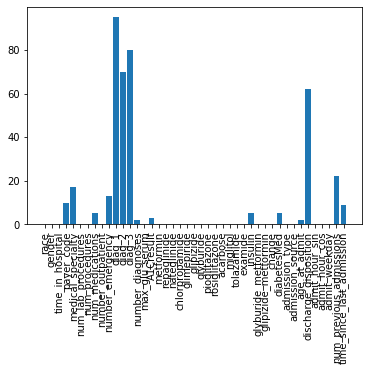

In [70]:
plt.xticks(rotation=90)
plt.bar(X.columns.values, best_lgb_base.feature_importance())

Base LightGBM model has perfect precision but terrible recall--the model misses way too many readmissions.
On the other side, if the model predicts readmission.

Let's see if another model can improve on that.

### Tensorflow

Before going forward, we need to adjust the training data.

LightGBM can handle categorical features directly without one-hot encoding beforehand--to work with other models I will create dummy variables for those categorical features.

In [71]:
X_dummies = pd.get_dummies(X, dummy_na=True)
X_dummies.shape

(101766, 2517)

In [72]:
any(X_dummies.isna().any())

False

In [73]:
# releasing lightgbm datasets
del dataset_train
del dataset_val
gc.collect()

40

In [74]:
del X_train, X_test, y_train, y_test
gc.collect()

20

Making new train-test split with one-hot-encoded categorical data

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, stratify=y, test_size=0.2, random_state=18)

In [76]:
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.backend import clear_session

In [77]:
model = Sequential()
model.add(Dense(X_dummies.shape[1], input_dim=X_dummies.shape[1], activation='relu'))
model.add(Dense(1500, activation='relu'))
model.add(Dense(1000, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2517)              6337806   
_________________________________________________________________
dense_1 (Dense)              (None, 1500)              3777000   
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1501000   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1001      
Total params: 11,616,807
Trainable params: 11,616,807
Non-trainable params: 0
_________________________________________________________________


In [78]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [79]:
model.fit(X_train, y_train, epochs=10, verbose=1, validation_data=(X_test, y_test))

Train on 81412 samples, validate on 20354 samples
Epoch 1/10
81412/81412 [==============================] - 14s 177us/sample - loss: 1.3780 - accuracy: 0.8813 - val_loss: 0.3407 - val_accuracy: 0.8883
Epoch 2/10
81412/81412 [==============================] - 14s 171us/sample - loss: 0.3458 - accuracy: 0.8883 - val_loss: 0.3841 - val_accuracy: 0.8884
Epoch 3/10
81412/81412 [==============================] - 14s 175us/sample - loss: 0.3444 - accuracy: 0.8884 - val_loss: 0.3541 - val_accuracy: 0.8874
Epoch 4/10
81412/81412 [==============================] - 14s 176us/sample - loss: 0.3406 - accuracy: 0.8884 - val_loss: 0.3430 - val_accuracy: 0.8875
Epoch 5/10
81412/81412 [==============================] - 14s 174us/sample - loss: 0.3385 - accuracy: 0.8885 - val_loss: 0.3435 - val_accuracy: 0.8881
Epoch 6/10
81412/81412 [==============================] - 14s 168us/sample - loss: 0.3359 - accuracy: 0.8893 - val_loss: 0.3457 - val_accuracy: 0.8855
Epoch 7/10
81412/81412 [====================

In [80]:
y_pred = model.predict(X_test)
evaluate_model_predictions(y_pred, y_test)

Accuracy:	0.8789
Precision:	0.2988
Recall:		0.0634
ROC_AUC:	0.6195


### Tensorflow pt. 2 - Undersampling

In [81]:
from imblearn.under_sampling import RandomUnderSampler

Using TensorFlow backend.


In [82]:
rus = RandomUnderSampler(random_state=18)
X_res, y_res = rus.fit_resample(X_train, y_train)

In [83]:
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 9086, 1: 9086})


Train same data on resampled data

In [85]:
model.fit(X_res, y_res, epochs=10, verbose=1, validation_data=(X_test, y_test))

Train on 18172 samples, validate on 20354 samples
Epoch 1/10
18172/18172 [==============================] - 4s 242us/sample - loss: 0.6353 - accuracy: 0.6010 - val_loss: 0.6842 - val_accuracy: 0.7761
Epoch 2/10
18172/18172 [==============================] - 4s 240us/sample - loss: 0.6110 - accuracy: 0.6187 - val_loss: 0.6585 - val_accuracy: 0.7795
Epoch 3/10
18172/18172 [==============================] - 4s 241us/sample - loss: 0.6028 - accuracy: 0.6228 - val_loss: 0.6785 - val_accuracy: 0.7682
Epoch 4/10
18172/18172 [==============================] - 4s 246us/sample - loss: 0.5954 - accuracy: 0.6277 - val_loss: 0.7383 - val_accuracy: 0.7808
Epoch 5/10
18172/18172 [==============================] - 4s 243us/sample - loss: 0.5888 - accuracy: 0.6336 - val_loss: 0.8330 - val_accuracy: 0.7421
Epoch 6/10
18172/18172 [==============================] - 4s 244us/sample - loss: 0.5813 - accuracy: 0.6375 - val_loss: 0.8070 - val_accuracy: 0.7392
Epoch 7/10
18172/18172 [==========================

Evaluate model using original test split--with its original imbalance.

In [86]:
y_pred = model.predict(X_test)
evaluate_model_predictions(y_pred, y_test)

Accuracy:	0.743
Precision:	0.1721
Recall:		0.3421
ROC_AUC:	0.5991


### Logistic Regression

Last but not least, there's the classic Logistic Regression model. Plain Jane or Ol' Reliable? Let's see...

In [87]:
from sklearn.linear_model import LogisticRegression

In [88]:
logreg = LogisticRegression()

In [89]:
logreg.fit(X_train, y_train)

C:\Users\Garrett\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [90]:
y_pred = logreg.predict_proba(X_test)

y_pred[:10]

array([[0.88107783, 0.11892217],
       [0.91878927, 0.08121073],
       [0.86250511, 0.13749489],
       [0.93199605, 0.06800395],
       [0.83821873, 0.16178127],
       [0.80009476, 0.19990524],
       [0.84735741, 0.15264259],
       [0.91255191, 0.08744809],
       [0.8586873 , 0.1413127 ],
       [0.92780163, 0.07219837]])

In [91]:
y_pred = [p[1] for p in y_pred]

In [92]:
evaluate_model_predictions(y_pred, y_test)

Accuracy:	0.888
Precision:	0.4
Recall:		0.007
ROC_AUC:	0.6415


Let's try the re-sampled training data.

In [93]:
logreg.fit(X_res, y_res)

C:\Users\Garrett\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [94]:
y_pred = logreg.predict_proba(X_test)
y_pred = [p[1] for p in y_pred]

evaluate_model_predictions(y_pred, y_test)

Accuracy:	0.6277
Precision:	0.1679
Recall:		0.5905
ROC_AUC:	0.6457


# Part 3 - Summary and Conclusion

In [95]:
# results taken from evaluations above
results = pd.DataFrame({'Model': ['LightGBM', 'TensorFlow', 'TensorFlow - Resampled', 'LogisticRegression', 'LogisticRegression - Resampled'], 
                        'Accuracy': [.8889, .8791, .743, .888, .6277],
                        'Precision': [1, .2759, .1721, .4, .1679],
                        'Recall': [.0044, .0515, .3421, .007, .5905], 
                        'AUC': [.6728, .5711, .5991, .6415, .6457]})

In [96]:
results

,Model,Accuracy,Precision,Recall,AUC
0,LightGBM,0.8889,1.0000,0.0044,0.6728
1,TensorFlow,0.8791,0.2759,0.0515,0.5711
2,TensorFlow - Resampled,0.7430,0.1721,0.3421,0.5991
3,LogisticRegression,0.8880,0.4000,0.0070,0.6415
4,LogisticRegression - Resampled,0.6277,0.1679,0.5905,0.6457


<BarContainer object of 5 artists>

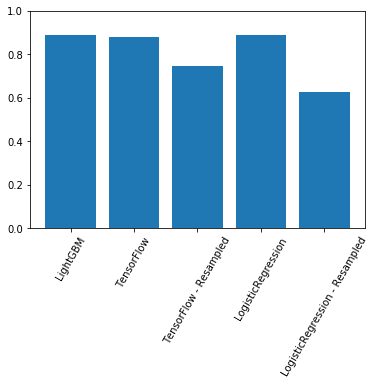

In [100]:
### Accuracy
plt.ylim(0, 1)
plt.xticks(rotation=60)
plt.bar(results['Model'], results['Accuracy'])

<BarContainer object of 5 artists>

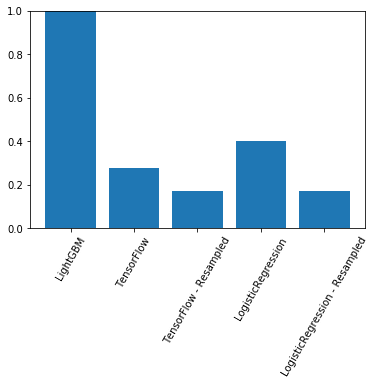

In [102]:
### Precision
plt.ylim(0, 1)
plt.xticks(rotation=60)
plt.bar(results['Model'], results['Precision'])

<BarContainer object of 5 artists>

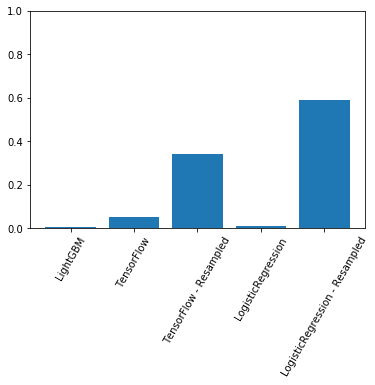

In [103]:
### Recall
plt.ylim(0, 1)
plt.xticks(rotation=60)
plt.bar(results['Model'], results['Recall'])

<BarContainer object of 5 artists>

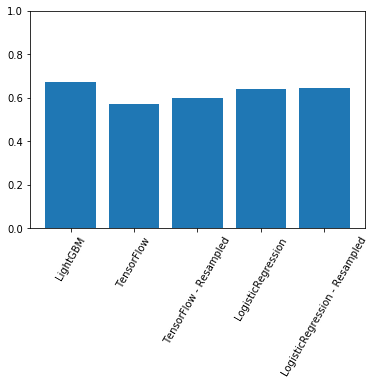

In [106]:
### ROC-AUC
plt.ylim(0, 1)
plt.xticks(rotation=60)
plot = plt.bar(results['Model'], results['AUC'])
plot